In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from scipy.ndimage import gaussian_filter1d
from math import floor
import leidenalg as la
import igraph as ig
import csv
import pickle
from glob import glob
from read_roi import read_roi_file, read_roi_zip
from elephant.spike_train_generation import homogeneous_poisson_process
import elephant.conversion as conv
import neo as n
import quantities as pq
from quantities import Hz, s, ms

In [2]:
def load_obj(path, name):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def read_spike_complexity(names, path_rois, path_spikes):
    epochs = ['_baseline', '_early', '_pre']
    all_spikes = {}
    for e in names:
        for f in epochs:
            n = read_roi(path_rois, e + f )
            spike = open(path_spikes + e + f + "_spikes_complexity.csv", "r")
            reader_spike = csv.reader(spike)
            spikes = np.zeros((n,8000))
            for i,line in enumerate(reader_spike):
                for j in range(len(line)):
                    spikes[i][j] = line[j]
            all_spikes[e+f] = spikes
            
    return(all_spikes)

def read_roi(path, subject_roi):
    
    roi = read_roi_zip(glob(path + subject_roi +'.zip')[0])
    n = len(roi)
    
    for i, R in enumerate(roi):
        x = roi[R]['x']
        y = roi[R]['y']
    return(n)

def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

def bin_time_series(array, binsize, gaussian = True, **kwargs):
    #input: nxt matrix 
    #returns: binned time series i.e. l x n x binsize
    
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    l = int(totalsize/binsize) # number of resulting layers
    if gaussian:
        for i in range(n):
            array[i] = gaussian_filter(array[i],kwargs['sigma'])
    
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = array[:,i*binsize:(i+1)*binsize]
    return(A)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def jitter(spike):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-5,5)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

def raster_plot(spikes, ax, s = 500, epochs = True): #plots the raster plot of the spike activity on a given axis 

        #be careful that neurons in different epochs are ordered differently
        n,t = spikes.shape
        
        #cmap = plt.cm.Spectral
        #norm = plt.Normalize(vmin = 0, vmax = float(np.max(spikes)))
        
        for i in range(n):
            for j in range(t):
                if spikes[i][j] == 0: pass
                else:
                    ax.scatter(j, i, s = 5, c = 'b', marker = 'x')#, norm = norm, cmap = cmap)
                    ax.set_title('Spike Raster Plot', fontsize = 20)
                    ax.set_xlabel('Time (Frames)', fontsize = 15)
                    ax.set_ylabel('Neuron ID', fontsize = 15)
                    ax.set_xticks([s*i for i in range(int(t/s)+1)])
                    ax.set_yticks([5*i for i in range(int(n/5)+1)]+[n])
                    ax.tick_params(axis = 'x', labelsize = 10)
                    ax.tick_params(axis = 'y', labelsize = 13)
        if epochs:pass
        else:ax.vlines([0,8000,16000],0,n+1, color = 'r')
                        
def concatenate(spikes, names): # concatanes the spike complexities of three epochs (baseline, early, pre) 
    #into single matrix. Some subjects have different number of ROIS in different epochs, so we just add zero rows
    ## to cover up that difference. 
    epochs = ['_baseline', '_early', '_pre']
    all_concatenated = {}
    for e in names:
        size = 0
        for i,f in enumerate(epochs):
            if spikes[e+f].shape[0] > size:
                size = spikes[e+f].shape[0]
        concatenated = np.zeros((size, 3*spikes[e+f].shape[1]))
        for i,f in enumerate(epochs):
            concatenated[0:spikes[e+f].shape[0],i*spikes[e+f].shape[1]:(i+1)*spikes[e+f].shape[1]] = spikes[e+f]
        all_concatenated[e] = concatenated
    return(all_concatenated)
    

def find_bin_size(array, spike_per_layer):
    
    array = bin_time_series(array, 500, array.shape[1])
    n, t, l = array.shape
    fouls = []
    
    for i in range(n):
        for j in range(l):
            if len(np.nonzero(array[i,:,j])[0]) < spike_per_layer:
                fouls.append('neuron %d in layer %d doesnt have enough spikes'%(i,j))
                
    return(fouls)

In [3]:
path_spikes = "/Users/bengieru/MLN/data/Johan_Clean_Traces_Features_and_Spikes/"
path_rois = "/Users/bengieru/MLN/data/sarah_ROI/"
path_subjects = "/Users/bengieru/MLN/subjects/"
epochs = ['_baseline', '_early', '_pre']

In [4]:
subjects = load_obj(path_subjects, 'subjects')

subject_names = subjects['het'] + subjects['wt']

all_spikes = read_spike_complexity(subject_names, path_rois, path_spikes)

all_concatenated = concatenate(all_spikes, subject_names)

In [5]:
spike_rates = [5,15,40]
time = 1000.0# in miliseconds
neurons = [3,23,4]
n = np.sum(neurons)
binsize = 200

In [6]:
master_train = []
for j,f in enumerate(neurons):
    spiketrain = [homogeneous_poisson_process(rate = spike_rates[j]*Hz, t_start = 0.0*ms, t_stop = time*ms, as_array=True) for i in range(neurons[j])]
    master_train.append(spiketrain)

In [7]:
spikes = np.zeros((n,int(time)))
count = 0
for i,e in enumerate(master_train):
    if i == 0:pass
    else:count = count + len(master_train[i-1])
    for j,f in enumerate(e):
        for k, g in enumerate(f):
            spikes[count+j][int(g)]=1

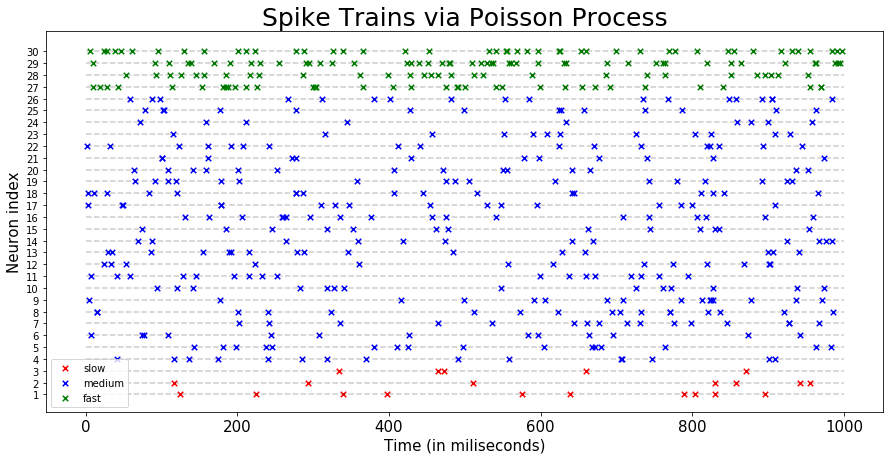

In [11]:
fig,ax = plt.subplots(1,1,figsize=(15,7))
count = 0
for k in range(len(master_train)):
    if k ==0:pass
    else:count = count + len(master_train[k-1])
    for i,e in enumerate(master_train[k]):
        ax.hlines(count+i+1,0,time, alpha=0.2, linestyle = '--')
        for j,f in enumerate(e):
            c = ['r','b','g']
            label = ['slow', 'medium', 'fast']
            if i+j == 0: ax.scatter(f,count+i+1, c = c[k], marker = 'x', s = 30, label = label[k])
            else:  ax.scatter(f,count+i+1, c = c[k], marker = 'x', s = 30)
ax.set_title('Spike Trains via Poisson Process', fontsize =25)
ax.set_xlabel('Time (in miliseconds)', fontsize = 15)
ax.set_ylabel('Neuron index', fontsize = 15)
ax.set_xticks([i*binsize for i in range(int(time/binsize))]+[time])
ax.tick_params(axis='x', labelsize = 15)
ax.set_yticks([i for i in range(1,30+1)])
#ax.vlines([(i+1)*binsize for i in range(int(time/binsize))], 1, neurons, alpha =0.2, color = 'b')
plt.legend()

Text(0.5, 0, 'TIME (in Miliseconds)')

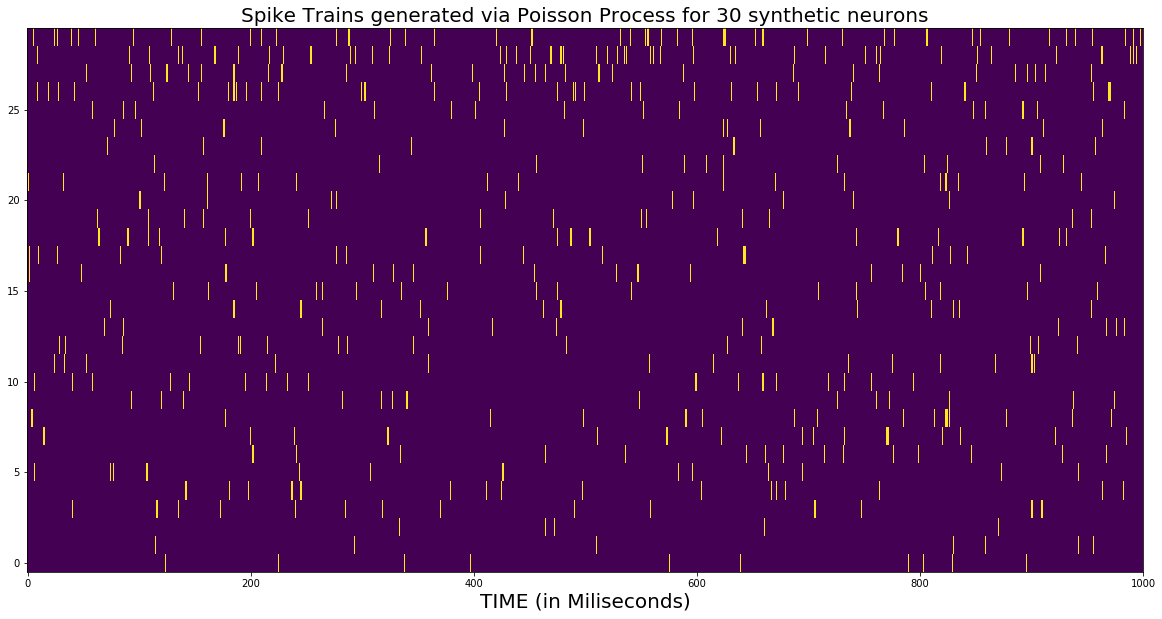

In [10]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(spikes, origin = 'bottom left', interpolation='nearest', aspect='auto')
ax.set_title('Spike Trains generated via Poisson Process for 30 synthetic neurons', fontsize= 20)
ax.set_xticks([i*binsize for i in range(int(time/binsize))]+[time])
ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)

In [12]:
numberofspikes = []
for i,e in enumerate(neurons):  
    for j in range(e):
        numberofspikes.append(len(master_train[i][j]))
numberofspikes

[10,
 7,
 5,
 15,
 16,
 13,
 16,
 17,
 16,
 14,
 17,
 13,
 16,
 12,
 13,
 18,
 16,
 17,
 17,
 14,
 12,
 17,
 12,
 9,
 14,
 18,
 35,
 29,
 47,
 45]

## Apply a fixed binsize

In [13]:
standard_dev = 1.2
layers = int(time/binsize)
binned_spikes = bin_time_series(spikes, binsize, gaussian = True, sigma = standard_dev) # bin the spikes into fixed length and apply gaussian kernel of length 3

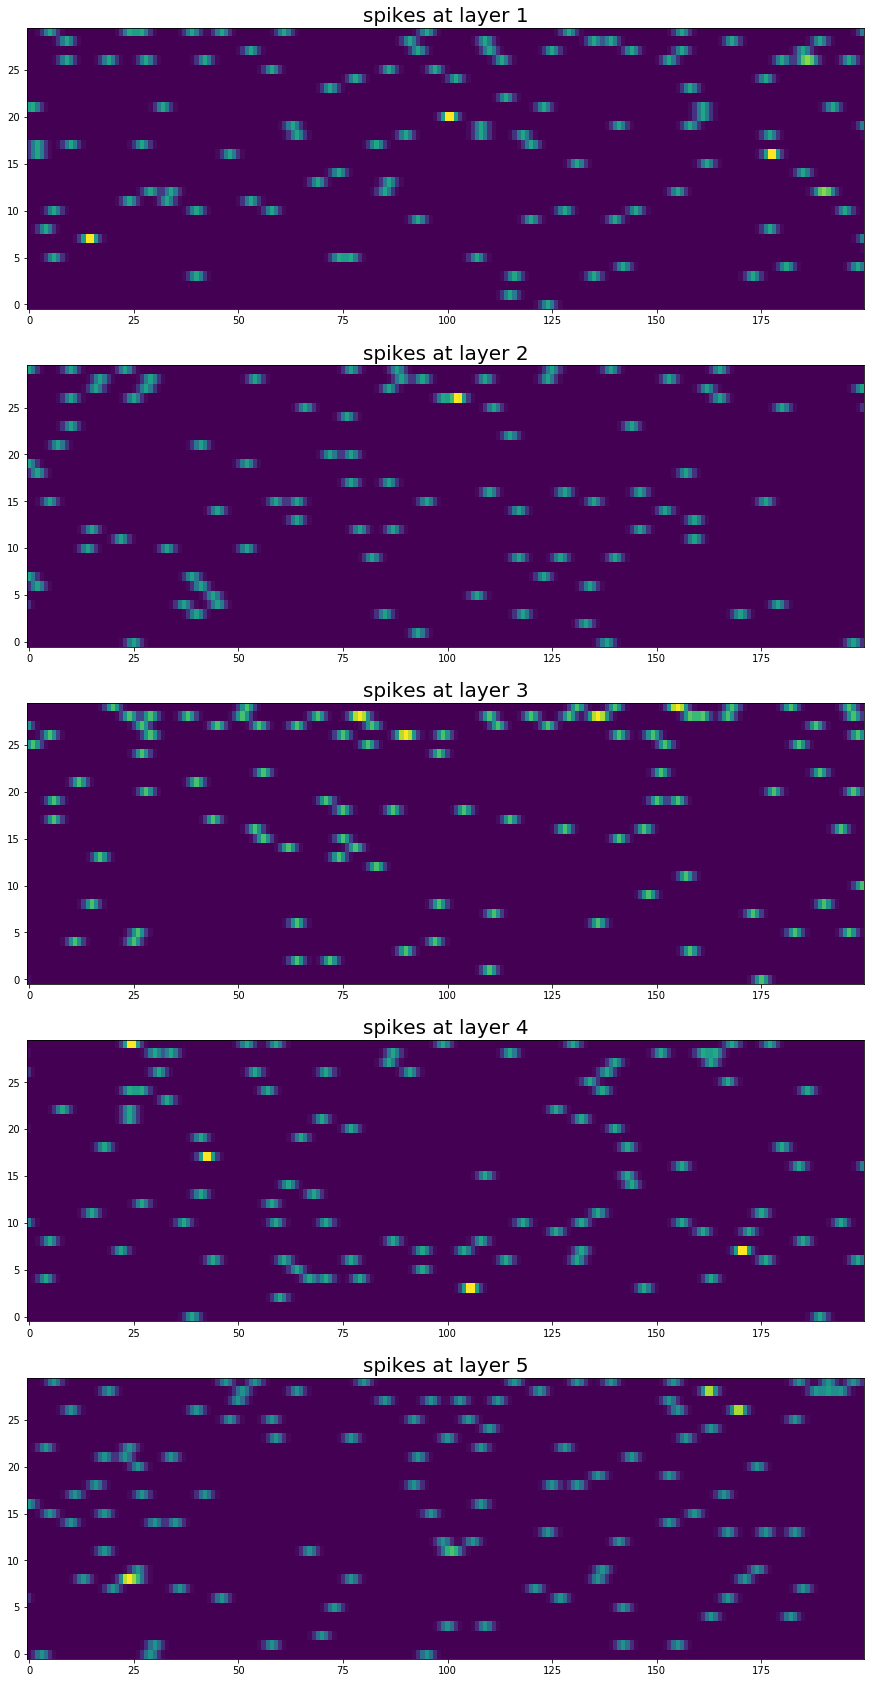

In [14]:
fig,ax = plt.subplots(layers,1,figsize=(15,30))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'bottom left', interpolation='nearest', aspect='auto')
    ax[i].set_title('spikes at layer %d'%(i+1), fontsize = 20)
#plt.tight_layout()

In [15]:
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


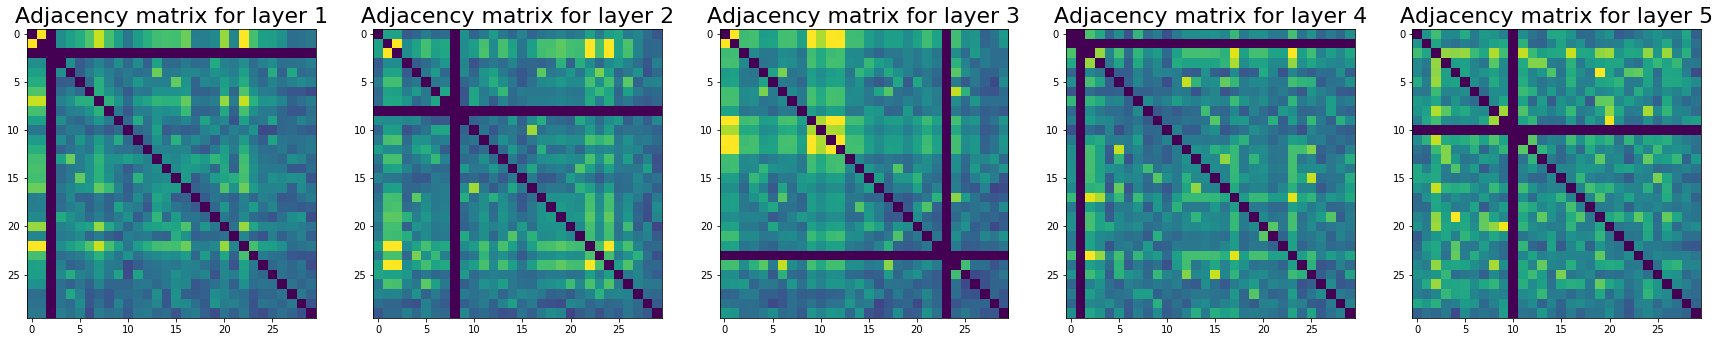

In [16]:
fig,ax = plt.subplots(1,layers,figsize=(30,12))
for i in range(layers):
    k = ax[i].imshow(adjacency_matrices[i])
    ax[i].set_title('Adjacency matrix for layer %d'%(i +1),fontsize=22)

## Apply an adaptive binsize chanigng according to the firing rates

In [32]:
binsizes = [200, 100, 50]
nindex = [0, 3, 26, 30]
layerss = [int(time/binsizes[i]) for i in range(len(binsizes))]

In [37]:
binned_spikes = [] # layers x number of neurons x binsize
for i in range(len(binsizes)):
    binned_spikes.append(bin_time_series(spikes[nindex[i]:nindex[i+1]], binsizes[i], gaussian = True, sigma = standard_dev)) # bin the spikes into fixed length and apply gaussian kernel of length 3

In [65]:
functional_conn = {}
for i in range(len(binsizes)):
    adjacency_matrices = []
    for j in range(layerss[i]):
        adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i][j])[0])
    functional_conn['%s'%binsizes[i]] = adjacency_matrices

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


In [68]:
binned_spikes[0][0].shape#functional_conn['50']

(3, 200)

In [69]:
functional_conn['200']

[array([[0.        , 0.99860446, 0.        ],
        [0.99860446, 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]),
 array([[0.        , 0.578114  , 0.56726418],
        [0.578114  , 0.        , 0.99379759],
        [0.56726418, 0.99379759, 0.        ]]),
 array([[0.        , 0.98330069, 0.66900011],
        [0.98330069, 0.        , 0.68903684],
        [0.66900011, 0.68903684, 0.        ]]),
 array([[0.        , 0.        , 0.71377459],
        [0.        , 0.        , 0.        ],
        [0.71377459, 0.        , 0.        ]]),
 array([[0.        , 0.46004164, 0.57061981],
        [0.46004164, 0.        , 0.48529128],
        [0.57061981, 0.48529128, 0.        ]])]